In [137]:
# univariate cnn lstm example
from numpy import array

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

import numpy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
from math import sqrt


# split a univariate sequence into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

# fixem random seed
numpy.random.seed(7)

dadesSau = read_csv('dadesBaells.csv', sep=';',header=0, index_col=0)
dataframe = pd.DataFrame(dadesSau.loc[dadesSau.index >= '2000-01-01']['Volum'])
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalitzem

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = [item for sublist in dataset for item in sublist]

n_steps_in = 30
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, dataset)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
#train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [138]:
# Create a random dataset
rng = np.random.RandomState(1)

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(train_X, train_Y)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(train_X, train_Y)

# Predict on new data
y_multirf = regr_multirf.predict(test_X)
y_rf = regr_rf.predict(test_X)

In [139]:
# prediccions
trainPredict = regr_rf.predict(train_X)
testPredict = regr_rf.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
trainPredict = scaler.inverse_transform(trainPredict)
train_YR = scaler.inverse_transform(train_Y)
testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(test_Y)


In [140]:
# prediccions
trainPredictM = regr_multirf.predict(train_X)
testPredictM = regr_multirf.predict(test_X)
# invertim prediccions per tenir-les en l'escala original
trainPredictM = scaler.inverse_transform(trainPredictM)
train_YRM = scaler.inverse_transform(train_Y)
testPredictM = scaler.inverse_transform(testPredictM)
test_YRM = scaler.inverse_transform(test_Y)

In [141]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [142]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

3.354890701194231


In [143]:
RMSE_M_TOT, RMSE_M_days = evaluate_forecasts(test_YRM,testPredictM)
print(RMSE_M_TOT)

3.3734728553032802


In [144]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒══════════╤═════════╤═════════╤═════════╤═════════╕
│    dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞══════════╪═════════╪═════════╪═════════╪═════════╡
│ 0.718343 │ 1.10072 │  1.4597 │  1.7923 │ 2.11613 │
╘══════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 2.44496 │  2.7851 │ 3.12249 │ 3.45581 │  3.77731 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  4.07801 │  4.35202 │  4.62724 │  4.89518 │   5.1615 │ 3.35489 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [145]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_M_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_M_days
ultim = v.append(RMSE_M_TOT)
table1 = tabulate([RMSE_M_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_M_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_M_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤══════════╤═════════╤═════════╤═════════╕
│   dia 1 │    dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪══════════╪═════════╪═════════╪═════════╡
│ 0.49263 │ 0.925924 │ 1.33841 │ 1.76413 │ 2.17382 │
╘═════════╧══════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│  2.5299 │ 2.83888 │ 3.16625 │ 3.52206 │  3.83084 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  4.14553 │  4.41929 │  4.62535 │  4.88242 │  5.14425 │ 3.37347 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [146]:
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_days[14],3))


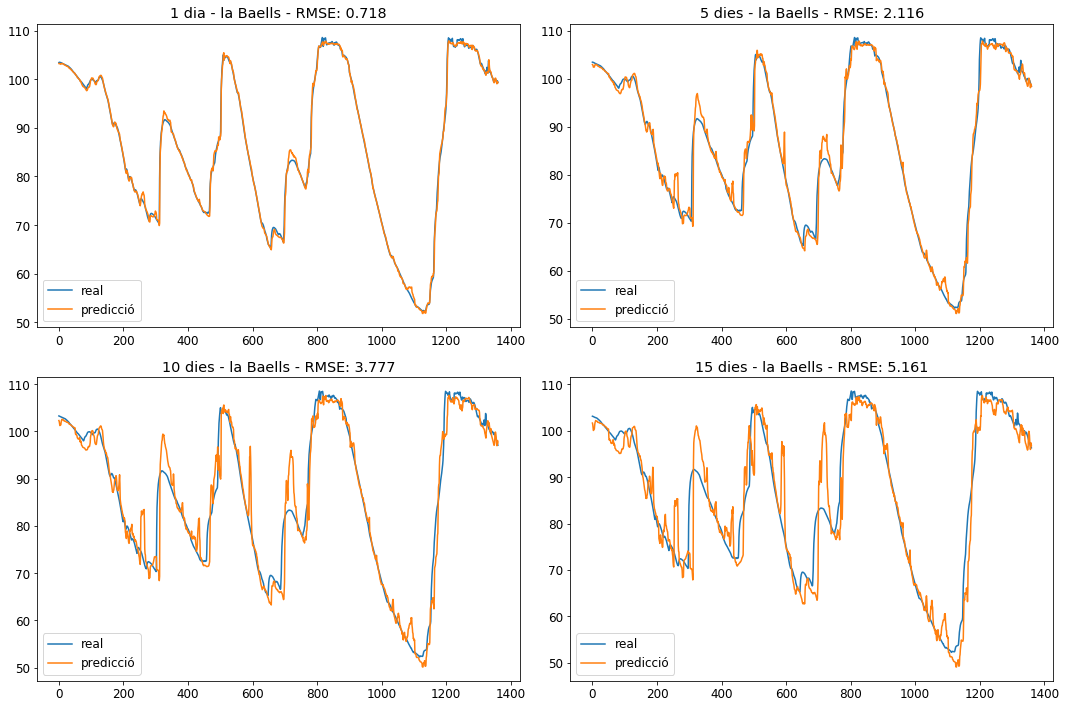

In [147]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [148]:
diesM= list()
    # calculem RMSE per cada dia
    
for i in range(test_YRM.shape[1]):
    # calculem MSE
    dies.append((test_YRM[:, i], testPredictM[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - la Baells - RMSE: '+str(round(RMSE_M_days[0],3))
title5 = '5 dies - la Baells - RMSE: '+str(round(RMSE_M_days[4],3))
title10 = '10 dies - la Baells - RMSE: '+str(round(RMSE_M_days[9],3))
title15 = '15 dies - la Baells - RMSE: '+str(round(RMSE_M_days[14],3))


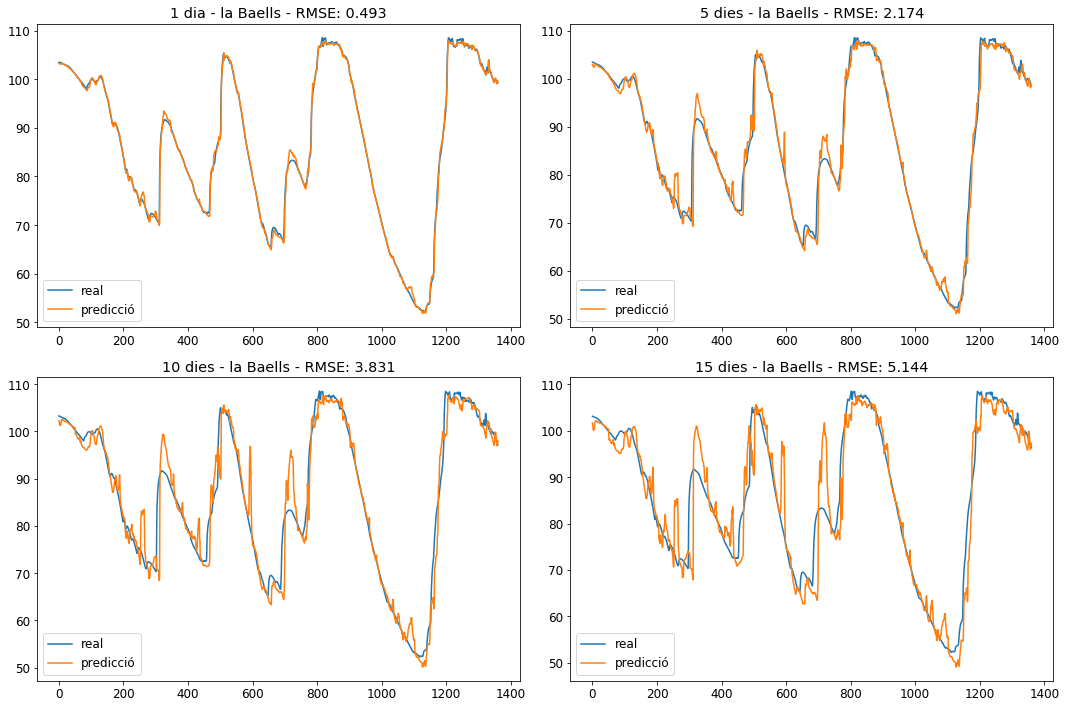

In [149]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [150]:
print(regr_multirf.get_params())

{'estimator__bootstrap': True, 'estimator__criterion': 'mse', 'estimator__max_depth': 30, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': 1, 'estimator__oob_score': False, 'estimator__random_state': 0, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False), 'n_jobs': 1}
